In [1]:
! pip freeze > requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# setting variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 100
BATCH_SIZE = 64
DATA_DIR = "../datasets/train_set_under500/"
cudnn.benchmark = True

In [3]:
# transforms to apply when loading data
data_transforms = {
        "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
        "val" : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}
# initialize dataset and dataloader
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes['train'], dataset_sizes['val'])
print((class_names))
print(torch.__version__)
print(DEVICE)

4048 1322
['Airplane', 'Ambulance', 'Bicycle', 'Bus', 'Car', 'Fire hydrant', 'Helicopter', 'Motorcycle', 'Parking meter', 'Stop sign', 'Taxi', 'Traffic sign', 'Truck']
1.12.1+cu113
cuda


In [4]:
# code reference from official pytorch transfer learning tutorial
def train(model, criterion, optimizer, scheduler):
    since = time.time()
    
    # save best weights
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(EPOCH):
        print(f'Epoch {epoch+1}/{EPOCH}')
        print('-' * 10)
        epoch_l.append(epoch+1)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # load data to cpu/gpu
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                
                # only update grad when training
                # predict value and compute loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # multiplying by size in case some batch is not full
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # control learning rate scheduler
            if phase == 'train':
                scheduler.step()

            # compute epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # record loss and accuracy
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu().numpy())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.cpu().numpy())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # compare accuracy 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            
        print()
    del loss, outputs # to avoid memory leak
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best weigths to model and return
    model.load_state_dict(best_weights)
    return model

In [5]:
# draw graph for traning accuracy and validation accuracy
def plot(epoch, t_l, v_l, title1, title2):
    fig, axes = plt.subplots()
    plt.subplot(2,1,1)
    plt.plot(epoch, t_l)
    plt.title(f'{title1}')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
        
    plt.subplot(2,1,2)
    plt.plot(epoch, v_l)
    plt.title(f'{title2}')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.tight_layout()
    plt.show()

Resnet / Resnext Model transfer learning

In [ ]:
# fine tuning without freezing layer
pre_trained = torchvision.models.resnet152(pretrained=True)

num_ftrs = pre_trained.fc.in_features
pre_trained.fc = nn.Linear(num_ftrs, len(class_names))

pre_trained = pre_trained.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre_trained.fc.parameters(), lr=0.0001)
#optimizer = optim.SGD(pre_trained.fc.parameters(), lr=0.0001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[5,15,40,80], gamma=0.1)

In [6]:
# training with freezing layer
pre_trained = torchvision.models.resnet152(pretrained=True)
#pre_trained = torchvision.models.resnext101_64x4d(weights='ResNeXt101_64X4D_Weights.DEFAULT')

# freeze layers
for param in pre_trained.parameters():
    param.requires_grad = False

# replace fully connected layer to the one that meets our need
num_ftrs = pre_trained.fc.in_features
pre_trained.fc = nn.Linear(num_ftrs, len(class_names))

# load model to device
pre_trained = pre_trained.to(DEVICE)
criterion = nn.CrossEntropyLoss()

# set optimizer for training
optimizer = optim.Adam(pre_trained.fc.parameters(), lr=1e-3, weight_decay=1e-5)
#optimizer = optim.SGD(pre_trained.fc.parameters(), lr=0.0015, momentum = 0.9)

# set learning rate scheduler for training
#exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,17,25,35], gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[5,10,15,40,70], gamma=0.1)

C:\Users\Everage\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Everage\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# training
torch.cuda.empty_cache()

epoch_l = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
fine_tuned = train(pre_trained, criterion, optimizer, exp_lr_scheduler)

Epoch 1/100
----------
train Loss: 1.2162 Acc: 0.6492
val Loss: 0.5692 Acc: 0.8336

Epoch 2/100
----------
train Loss: 0.6392 Acc: 0.8125
val Loss: 0.4494 Acc: 0.8638

Epoch 3/100
----------
train Loss: 0.5738 Acc: 0.8244
val Loss: 0.4956 Acc: 0.8283

Epoch 4/100
----------
train Loss: 0.5950 Acc: 0.8058
val Loss: 0.3886 Acc: 0.8782

Epoch 5/100
----------
train Loss: 0.5510 Acc: 0.8179
val Loss: 0.3967 Acc: 0.8669

Epoch 6/100
----------
train Loss: 0.4925 Acc: 0.8431
val Loss: 0.3916 Acc: 0.8684

Epoch 7/100
----------
train Loss: 0.4988 Acc: 0.8424
val Loss: 0.3859 Acc: 0.8729

Epoch 8/100
----------
train Loss: 0.5108 Acc: 0.8402
val Loss: 0.3796 Acc: 0.8767

Epoch 9/100
----------
train Loss: 0.4838 Acc: 0.8500
val Loss: 0.3760 Acc: 0.8752

Epoch 10/100
----------
train Loss: 0.5046 Acc: 0.8421
val Loss: 0.3814 Acc: 0.8691

Epoch 11/100
----------
train Loss: 0.4886 Acc: 0.8468
val Loss: 0.3851 Acc: 0.8714

Epoch 12/100
----------
train Loss: 0.4991 Acc: 0.8429
val Loss: 0.3769 Ac

val Loss: 0.3868 Acc: 0.8729

Epoch 98/100
----------
train Loss: 0.4734 Acc: 0.8530
val Loss: 0.3777 Acc: 0.8767

Epoch 99/100
----------
train Loss: 0.4717 Acc: 0.8520
val Loss: 0.3761 Acc: 0.8729

Epoch 100/100
----------
train Loss: 0.4742 Acc: 0.8496
val Loss: 0.3792 Acc: 0.8722

Training complete in 92m 12s
Best val Acc: 0.879728


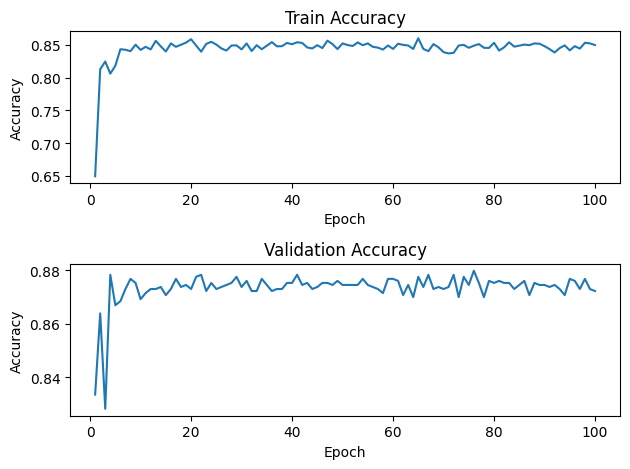

In [8]:
plot(epoch_l, train_acc, val_acc, "Train Accuracy", "Validation Accuracy")

In [9]:
torch.save(fine_tuned.state_dict(), "../weights/resnet152_OI_100ep.pth")

VGG Model Transfer learning

In [6]:
pre_trained = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

for param in pre_trained.features.parameters():
    param.requires_grad = False

num_ftrs = pre_trained.classifier[-1].in_features
pre_trained.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

pre_trained = pre_trained.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pre_trained.classifier.parameters(), lr=1e-3, weight_decay=1e-5)
#exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,17,25,35], gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[5,10,15,40,70], gamma=0.1)

In [7]:
torch.cuda.empty_cache()

epoch_l = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
vgg19_fine_tuned = train(pre_trained, criterion, optimizer, exp_lr_scheduler)

Epoch 1/100
----------
train Loss: 1.4236 Acc: 0.5835
val Loss: 0.8788 Acc: 0.7307

Epoch 2/100
----------
train Loss: 1.0438 Acc: 0.6927
val Loss: 0.6832 Acc: 0.7943

Epoch 3/100
----------
train Loss: 1.0481 Acc: 0.6897
val Loss: 0.6995 Acc: 0.7905

Epoch 4/100
----------
train Loss: 0.9500 Acc: 0.7236
val Loss: 0.5907 Acc: 0.8116

Epoch 5/100
----------
train Loss: 0.9448 Acc: 0.7241
val Loss: 0.7677 Acc: 0.7693

Epoch 6/100
----------
train Loss: 0.8177 Acc: 0.7498
val Loss: 0.6072 Acc: 0.8207

Epoch 7/100
----------
train Loss: 0.6936 Acc: 0.7863
val Loss: 0.5583 Acc: 0.8298

Epoch 8/100
----------
train Loss: 0.6827 Acc: 0.7853
val Loss: 0.5562 Acc: 0.8306

Epoch 9/100
----------
train Loss: 0.6443 Acc: 0.7989
val Loss: 0.5346 Acc: 0.8396

Epoch 10/100
----------
train Loss: 0.5947 Acc: 0.8157
val Loss: 0.5271 Acc: 0.8343

Epoch 11/100
----------
train Loss: 0.5481 Acc: 0.8160
val Loss: 0.5265 Acc: 0.8381

Epoch 12/100
----------
train Loss: 0.5872 Acc: 0.8177
val Loss: 0.5285 Ac

val Loss: 0.5258 Acc: 0.8404

Epoch 98/100
----------
train Loss: 0.5856 Acc: 0.8147
val Loss: 0.5258 Acc: 0.8404

Epoch 99/100
----------
train Loss: 0.5670 Acc: 0.8209
val Loss: 0.5258 Acc: 0.8404

Epoch 100/100
----------
train Loss: 0.5705 Acc: 0.8167
val Loss: 0.5258 Acc: 0.8404

Training complete in 76m 44s
Best val Acc: 0.841150


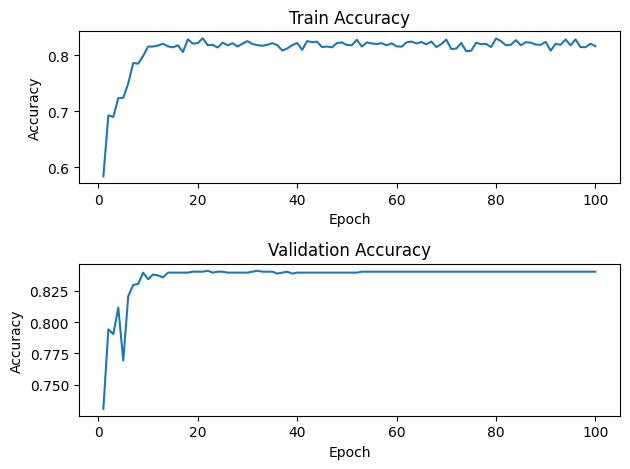

In [8]:
plot(epoch_l, train_acc, val_acc, "Train Accuracy", "Validation Accuracy")

In [9]:
torch.save(vgg19_fine_tuned.state_dict(), "../weights/vgg16_OI_100ep.pth")